To Do: 

* EfficientNetB0

* MobileNetV2

* EfficientNetV2B3

* Resnet50

* DenseNet121

* InceptionV3

# **1-Checking GPU**

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1650 (UUID: GPU-53a3e216-6706-e120-b818-40b8c0b04c26)


# **2- Import Libraries**

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **3- Import Functions from helping function**

In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

# **4- import dataset**

In [ ]:
import splitfolders

splitfolders.ratio("../../data/", output="output_1",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

In [ ]:
#How many images/classes are there?
walk_through_dir("output_1")

In [10]:
train_dir_1 = "../../dataset/train/"
val_dir_1 = "../../dataset/val/"
test_dir_1 = "../../dataset/test"

In [11]:
#How many images/classes are there?
walk_through_dir("../../dataset")

There are 3 directories and 0 images in '../../dataset'.
There are 0 directories and 33 images in '../../dataset\test'.
There are 38 directories and 0 images in '../../dataset\train'.
There are 0 directories and 2016 images in '../../dataset\train\Apple___Apple_scab'.
There are 0 directories and 1987 images in '../../dataset\train\Apple___Black_rot'.
There are 0 directories and 1760 images in '../../dataset\train\Apple___Cedar_apple_rust'.
There are 0 directories and 2008 images in '../../dataset\train\Apple___healthy'.
There are 0 directories and 1816 images in '../../dataset\train\Blueberry___healthy'.
There are 0 directories and 1826 images in '../../dataset\train\Cherry_(including_sour)___healthy'.
There are 0 directories and 1683 images in '../../dataset\train\Cherry_(including_sour)___Powdery_mildew'.
There are 0 directories and 1642 images in '../../dataset\train\Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'.
There are 0 directories and 1907 images in '../../dataset\train\

# **5- Setup data inputs**

In [9]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1,
                                                                label_mode="categorical",
                                                                 batch_size=32,
                                                                image_size=IMG_SIZE,
                                                                 seed=42,
                                                                 shuffle=True)
val_data =  tf.keras.preprocessing.image_dataset_from_directory(val_dir_1,
                                                                 batch_size=32,                                                                
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                seed=42,
                                                                 shuffle=False) # don't shuffle test data for prediction analysis

test_data =  tf.keras.preprocessing.image_dataset_from_directory(test_dir_1,
                                                                 batch_size=32,                                                                
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE,
                                                                 seed=42,
                                                                 shuffle=False) # don't shuffle test data for prediction analysis

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.
Found 0 files belonging to 0 classes.


ValueError: No images found in directory ../../dataset/test/. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

# **6- Create Checkpoint Callback**

In [7]:
# Create a checkpoint callback
checkpoint_path = "model_checkpoints"
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=2, verbose=1)

mc = ModelCheckpoint(monitor="val_accuracy",filepath=checkpoint_path, min_delta=0.01, patience=3, verbose=1, save_best_only=True)

cb = [es, mc]

# **7- Data Augmentation**

In [12]:
# Create a data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
   preprocessing.RandomFlip("horizontal"),
   preprocessing.RandomRotation(0.2),
   preprocessing.RandomHeight(0.2),
   preprocessing.RandomWidth(0.2),
   preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.)  # rescale inputs of images between 1 & 0, required for models like ResNet50                            
], name= "data_augmentation")



# **Model 1 (EfficientNetB0)**

In [13]:
# Setup a base model and freeze its layer (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup a model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment layers (only happens during trainable phase)
x = base_model(x, training=False) # put the base model in interface mode so weights which needs to be frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model=tf.keras.Model(inputs, outputs)

In [14]:
# Get a summary of model we've been created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 38)                48678     
                                                                 
Total params: 4,098,249
Trainable params: 48,678
Non-trainabl

## **14-Applying Feature Extraction**

In [15]:
from tensorflow.keras import metrics

METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')
]

In [16]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=METRICS)

# Fit
history = model.fit(train_data,
                    epochs=5, # fit to 5 epochs to keep experiment quick
                    validation_data=val_data,
                    validation_steps=len(val_data))

Epoch 1/5
  26/2197 [..............................] - ETA: 46:55 - loss: 3.2818 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 30784.0000 - fn: 832.0000 - accuracy: 0.1755 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7182

## **15-Evaluate Whole Dataset**

In [13]:
# Evaluate on the whole test dataset  ##its a feature extraction instead of fine tune
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

InvalidArgumentError: Graph execution error:

Detected at node 'LogicalAnd' defined at (most recent call last):
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\m7abu\AppData\Local\Temp\ipykernel_5772\3325030990.py", line 2, in <module>
      feature_extraction_results = model.evaluate(test_data)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1668, in test_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1092, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\engine\compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\utils\metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\metrics\base_metric.py", line 143, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\metrics\metrics.py", line 513, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\utils\metrics_utils.py", line 791, in update_confusion_matrix_variables
      weighted_assign_add(
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\utils\metrics_utils.py", line 762, in weighted_assign_add
      label_and_pred = tf.cast(tf.logical_and(label, pred), dtype=var.dtype)
Node: 'LogicalAnd'
Incompatible shapes: [1,1216] vs. [1,32]
	 [[{{node LogicalAnd}}]] [Op:__inference_test_function_175013]

## **16-Graph of Feature Extraction**

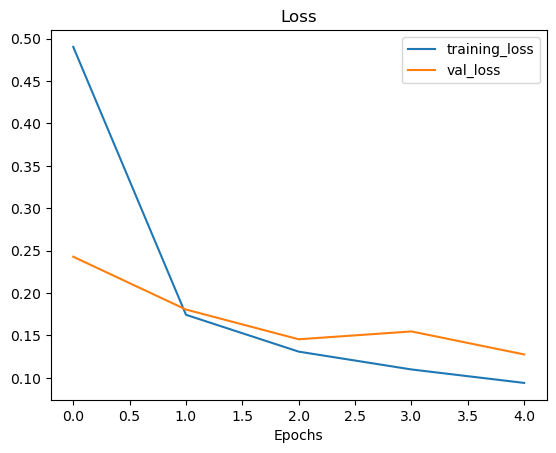

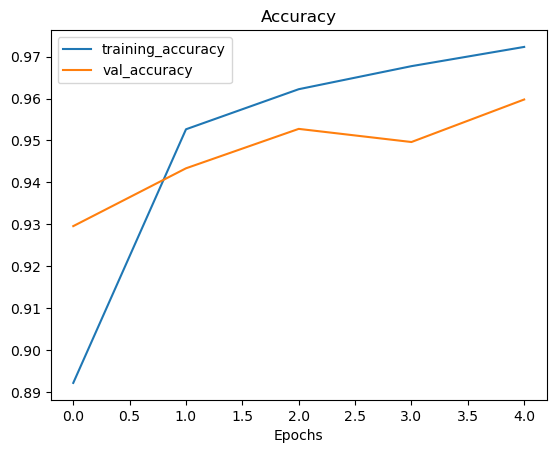

In [14]:
plot_loss_curves(history)

## **17-Fine-Tuning Model Using EfficientNetB0**

In [15]:
# Unfreeze all of the layers in base model
base_model.trainable=True

# Refreeze every layer except the last 5 layer 
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [16]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lower by 10x
              metrics=METRICS)

In [17]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pooling_layer True
output_layer True


In [18]:
# Check which layers in our model is trainable
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable )

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [19]:
# Fine-tune for more 5 epochs
fine_tune_epochs = 5 # model has already done the 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 =10)

# Fine-tune our model
history_fine_tune = model.fit(train_data,
                              epochs=fine_tune_epochs,
                              validation_data=val_data,
                              validation_steps=len(val_data),
                              initial_epoch=history.epoch[-1])

Epoch 5/5
2197/2197 [==============================] - 3323s 1s/step - loss: 0.0773 - tp: 68189.0000 - fp: 1510.0000 - tn: 2599405.0000 - fn: 2106.0000 - accuracy: 0.9736 - precision: 0.9783 - recall: 0.9700 - auc: 0.9996 - val_loss: 0.0862 - val_tp: 16998.0000 - val_fp: 468.0000 - val_tn: 649696.0000 - val_fn: 574.0000 - val_accuracy: 0.9700 - val_precision: 0.9732 - val_recall: 0.9673 - val_auc: 0.9995


## **18- Evaluate Fine-Tune Model**

In [20]:
# Evaluate on the whole test dataset
fine_tune_results =model.evaluate(test_data)
fine_tune_results

InvalidArgumentError: Graph execution error:

Detected at node 'LogicalAnd' defined at (most recent call last):
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\m7abu\AppData\Local\Temp\ipykernel_5772\1462663032.py", line 2, in <module>
      fine_tune_results =model.evaluate(test_data)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1668, in test_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\engine\training.py", line 1092, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\engine\compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\utils\metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\metrics\base_metric.py", line 143, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\metrics\metrics.py", line 513, in update_state
      return metrics_utils.update_confusion_matrix_variables(
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\utils\metrics_utils.py", line 791, in update_confusion_matrix_variables
      weighted_assign_add(
    File "c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\keras\utils\metrics_utils.py", line 762, in weighted_assign_add
      label_and_pred = tf.cast(tf.logical_and(label, pred), dtype=var.dtype)
Node: 'LogicalAnd'
Incompatible shapes: [1,1216] vs. [1,32]
	 [[{{node LogicalAnd}}]] [Op:__inference_test_function_222370]

## **19-Compare The Histories**

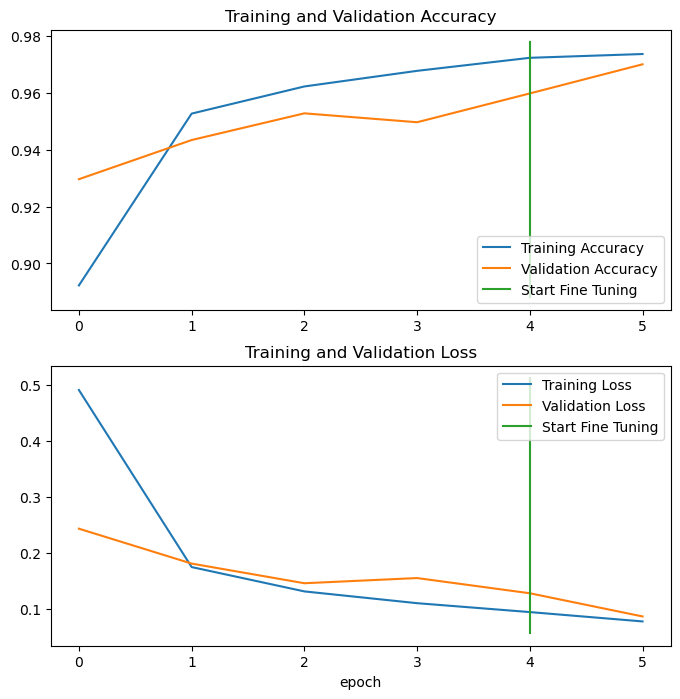

In [21]:
# Compare the historys of feature extraction model with fine-tuning model 
compare_historys(original_history=history,
                 new_history=history_fine_tune,
                 initial_epochs=5)

## **20-Saving and Loading The Model**

In [27]:
model.save('models/plant_disease_detector')

INFO:tensorflow:Assets written to: models/plant_disease_detector\assets


INFO:tensorflow:Assets written to: models/plant_disease_detector\assets


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

## **Make Prediction with Trained Model**

In [28]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long it left

2/2 [==============================] - 7s 951ms/step


In [29]:
len(test_data)

2

In [30]:
# How many predictions are there?
len(preds_probs)

33

In [31]:
# What's the shape of our predictions?
preds_probs.shape

(33, 38)

In [32]:
# Let's see whats the first 10 predictions looks like
preds_probs[:10]

array([[3.28763825e-04, 4.11010575e-07, 9.99670267e-01, 4.91794439e-10,
        9.26692749e-08, 4.05982448e-09, 3.47241041e-10, 4.16345881e-11,
        1.85580740e-09, 4.84731179e-12, 9.30351456e-12, 1.40549372e-09,
        3.67312014e-10, 2.25182784e-09, 2.79220602e-09, 2.52834021e-11,
        2.39427989e-09, 1.63144021e-09, 2.05390052e-10, 7.07020931e-09,
        1.25903711e-07, 3.01476011e-10, 2.14446544e-07, 1.49677764e-08,
        4.58991135e-12, 3.03414099e-11, 4.93595442e-12, 3.75614297e-12,
        4.38498792e-13, 1.42932721e-09, 2.53247538e-08, 2.11861657e-11,
        1.23024715e-10, 9.20041427e-14, 4.14042809e-08, 5.72130928e-12,
        3.43705231e-10, 1.14191534e-09],
       [3.65127635e-05, 3.26972258e-05, 9.99509037e-01, 3.59889789e-04,
        4.09958630e-11, 2.43080763e-06, 5.73462966e-09, 1.95546045e-06,
        6.95042246e-10, 1.49111770e-07, 3.40047920e-11, 3.46320885e-05,
        6.02876696e-07, 4.87702962e-08, 2.36729292e-07, 1.46789136e-10,
        1.34008187e-05,

In [33]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([3.2876382e-04, 4.1101057e-07, 9.9967027e-01, 4.9179444e-10,
        9.2669275e-08, 4.0598245e-09, 3.4724104e-10, 4.1634588e-11,
        1.8558074e-09, 4.8473118e-12, 9.3035146e-12, 1.4054937e-09,
        3.6731201e-10, 2.2518278e-09, 2.7922060e-09, 2.5283402e-11,
        2.3942799e-09, 1.6314402e-09, 2.0539005e-10, 7.0702093e-09,
        1.2590371e-07, 3.0147601e-10, 2.1444654e-07, 1.4967776e-08,
        4.5899114e-12, 3.0341410e-11, 4.9359544e-12, 3.7561430e-12,
        4.3849879e-13, 1.4293272e-09, 2.5324754e-08, 2.1186166e-11,
        1.2302472e-10, 9.2004143e-14, 4.1404281e-08, 5.7213093e-12,
        3.4370523e-10, 1.1419153e-09], dtype=float32),
 38,
 0.999999985021078)

In [34]:
# We get one prediction probability per class(in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilites for sample 0: {len(preds_probs[0])}")
print(f"What prediction probabilites sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")


Number of prediction probabilites for sample 0: 38
What prediction probabilites sample 0 looks like:
 [3.2876382e-04 4.1101057e-07 9.9967027e-01 4.9179444e-10 9.2669275e-08
 4.0598245e-09 3.4724104e-10 4.1634588e-11 1.8558074e-09 4.8473118e-12
 9.3035146e-12 1.4054937e-09 3.6731201e-10 2.2518278e-09 2.7922060e-09
 2.5283402e-11 2.3942799e-09 1.6314402e-09 2.0539005e-10 7.0702093e-09
 1.2590371e-07 3.0147601e-10 2.1444654e-07 1.4967776e-08 4.5899114e-12
 3.0341410e-11 4.9359544e-12 3.7561430e-12 4.3849879e-13 1.4293272e-09
 2.5324754e-08 2.1186166e-11 1.2302472e-10 9.2004143e-14 4.1404281e-08
 5.7213093e-12 3.4370523e-10 1.1419153e-09]
The class with highest predicted probability by the model for sample 0: 2


In [35]:
# Get the pred classes of each model
pred_classes = preds_probs.argmax(axis=1)

# How do they look like?
pred_classes[:10]

array([2, 2, 2, 2, 0, 0, 0, 8, 8, 8], dtype=int64)

In [36]:
# How many pred classes we have?
len(pred_classes)

33

In [37]:
# To get our test dataset labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1,.....0,0], we want the index value where the index value "1" occurs
y_labels[:10] # look at the first 10 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [38]:
# How many y_labels are there?
len(y_labels)

33

## **22 Confusion Matrix**

In [39]:
# The results from the saved model (Above) should be very similar to the results below
fine_tune_results

NameError: name 'fine_tune_results' is not defined

In [40]:
# Get a list of class names
class_names =test_data.class_names
class_names[:10]

['test']

In [41]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-label print verticaly
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### changes (x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [42]:
make_confusion_matrix(y_true=y_labels,
                       y_pred=pred_classes,
                       classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

C:\Users\m7abu\AppData\Local\Temp\ipykernel_5772\2950257450.py:34: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it


ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of labels (1).

## **23- Classification Report**

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.09      0.17        33
           2       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         0
          22       0.00      0.00      0.00         0
          29       0.00      0.00      0.00         0
          30       0.00      0.00      0.00         0
          35       0.00      0.00      0.00         0
          37       0.00      0.00      0.00         0

    accuracy                           0.09        33
   macro avg       0.11      0.01      0.02        33
weighted avg       1.00      0.09      0.17        33



c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\m7abu\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0': {'precision': 1.0,
  'recall': 0.09090909090909091,
  'f1-score': 0.16666666666666669,
  'support': 33.0},
 '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '20': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '22': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '29': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '30': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '35': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 '37': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0},
 'accuracy': 0.09090909090909091,
 'macro avg': {'precision': 0.1111111111111111,
  'recall': 0.010101010101010102,
  'f1-score': 0.01851851851851852,
  'support': 33.0},
 'weighted avg': {'precision': 1.0,
  'recall': 0.09090909090909091,
  'f1-score': 0.16666666666666669,
  'support': 3

In [46]:
class_names[7]

IndexError: list index out of range

In [ ]:
classification_report_dict["37"]["f1-score"]

In [47]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
     # Add names and f1-scores to new dictionary
     class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores     


IndexError: list index out of range

In [48]:
# Turn f1 scores into Dataframe visualization
import pandas as pd
f1_scores =pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                        "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores                        

,class_names,f1-score
0,test,0.166667


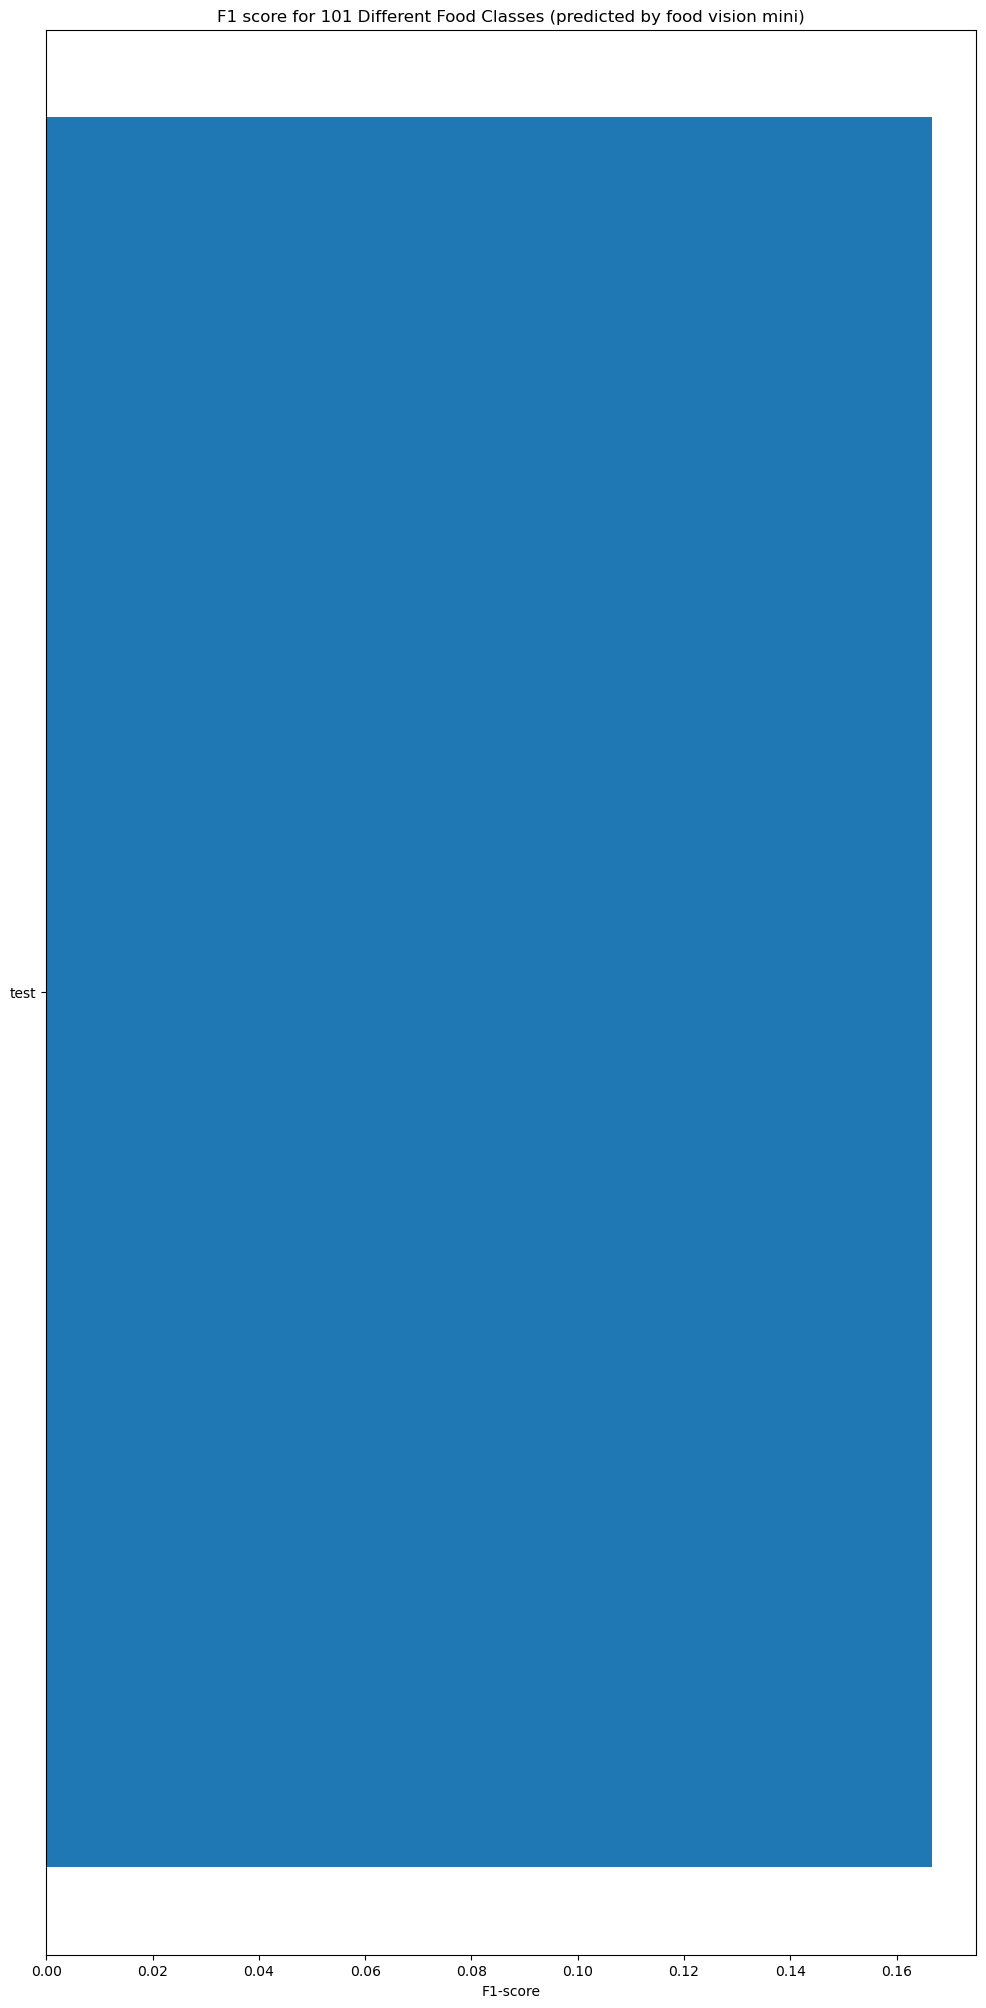

In [ ]:
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score value
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1 score for 101 Different Food Classes (predicted by food vision mini)")
ax.invert_yaxis(); # reverse the order of our plot


# Challenge: add value to the end of each bar of what the actual f1-score is 
# (hint: use the "autolabel" function from here: https://matplotlib.org/2.0.2/examples/api/barchart_demo.html) 

In [50]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\m7abu\AppData\Local\Temp\tmpp7hrbr68\assets


INFO:tensorflow:Assets written to: C:\Users\m7abu\AppData\Local\Temp\tmpp7hrbr68\assets
